In [1]:
# Importing all necessary libraries to proceed with this project.
import os
import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
#import catboost as cb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
# Import timedelta from datetime library
from datetime import timedelta

ss = StandardScaler()
'done'

'done'

In [2]:
# Set the desired directory path
dir_path = r'C:\Users\Eeshan\Desktop\University\walmart-store-sales-forecasting\data'

# Set the directory path as the working directory
os.chdir(dir_path)

# Verify the new working directory
updated_dir = os.getcwd()
print("Updated working directory:", updated_dir)

#test = pd.read_csv('test.csv')
walmart = pd.read_csv('train.csv')
store = pd.read_csv('stores.csv')
feature = pd.read_csv('features.csv')

Updated working directory: C:\Users\Eeshan\Desktop\University\walmart-store-sales-forecasting\data


In [3]:
walmart.shape

(421570, 5)

In [4]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [8]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


Here we see that there are no missing values in this data, thats great!
But now we see that the Date is of object data-type, and IsHoliday a boolean too. We'll change that soon.
Also, the Store and Dept, though it migh be int but that is categorical column so that needs to be chahnged too.

Since we are predicting the weekly sales for Store level, we will be grouping the data in walmart dataset to avoid the department and take the sum of department sales to store level.

In [9]:
store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
store_group.reset_index(inplace=True)
store_group

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68
...,...,...,...
6430,45,2012-09-28,713173.95
6431,45,2012-10-05,733455.07
6432,45,2012-10-12,734464.36
6433,45,2012-10-19,718125.53


Merging all the datasets into one place for easier test and analysis.


In [10]:
result = pd.merge(store_group, store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

In [11]:
print(data.shape)
data.info()

(6435, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Type          6435 non-null   object 
 4   Size          6435 non-null   int64  
 5   Temperature   6435 non-null   float64
 6   Fuel_Price    6435 non-null   float64
 7   MarkDown1     2280 non-null   float64
 8   MarkDown2     1637 non-null   float64
 9   MarkDown3     2046 non-null   float64
 10  MarkDown4     1965 non-null   float64
 11  MarkDown5     2295 non-null   float64
 12  CPI           6435 non-null   float64
 13  Unemployment  6435 non-null   float64
 14  IsHoliday     6435 non-null   bool   
dtypes: bool(1), float64(10), int64(2), object(2)
memory usage: 760.4+ KB


In [12]:
data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x == True else 0)

In [13]:
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
dtype: object

In [14]:
data["Date"]=pd.to_datetime(data.Date)
data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year
data['Week'] = data.Date.dt.isocalendar().week 

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [15]:
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
Week               0
dtype: int64

In [16]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Size,6435.0,1.302876e+05,63117.022465,34875.000,70713.000,126512.000000,2.023070e+05,2.196220e+05
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
MarkDown1,2280.0,6.855587e+03,8183.310015,0.270,1679.190,4972.590000,8.873583e+03,8.864676e+04
MarkDown2,1637.0,3.218966e+03,9268.082387,-265.760,37.200,187.040000,1.785290e+03,1.045195e+05
MarkDown3,2046.0,1.349853e+03,9287.242800,-29.100,4.700,22.700000,9.998750e+01,1.416306e+05
MarkDown4,1965.0,3.303858e+03,6211.203947,0.220,483.270,1419.420000,3.496080e+03,6.747485e+04
MarkDown5,2295.0,4.435262e+03,5868.933325,135.160,1702.565,3186.520000,5.422080e+03,1.085193e+05


EDA

TIME SERIES ANALYSIS

In [17]:
data1 = pd.read_csv('train.csv')
data1.set_index('Date', inplace=True)

data1["Weekly_Sales"]=data1.Weekly_Sales/1000

store4 = data1[data1.Store == 4]
# there are about 45 different stores in this dataset.

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)

In [18]:
store1 = data1[data1.Store == 43]
# there are about 45 different stores in this dataset.

sales1 = pd.DataFrame(store1.Weekly_Sales.groupby(store1.index).sum())
sales1.dtypes
sales1.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales1.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales1['Date'] = pd.to_datetime(sales1['Date'])
# resetting date back to the index
sales1.set_index('Date',inplace = True)

In [19]:
store3 = data1[data1.Store == 42]
# there are about 45 different stores in this dataset.

sales3 = pd.DataFrame(store3.Weekly_Sales.groupby(store3.index).sum())
sales3.dtypes
sales3.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales3.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales3['Date'] = pd.to_datetime(sales3['Date'])
# resetting date back to the index
sales3.set_index('Date',inplace = True)

In [20]:
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]
# there are about 45 different stores in this dataset.

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)

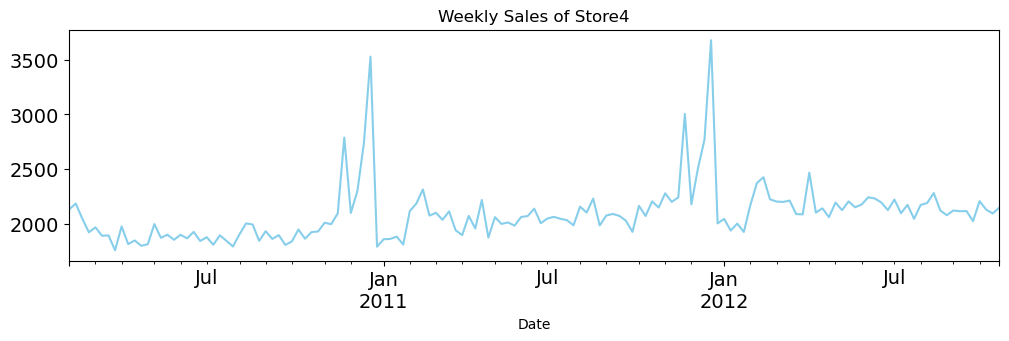

In [21]:


sales4.Weekly_Sales.plot(figsize=(12,3), title= 'Weekly Sales of Store4', fontsize=14, color = 'skyblue')
plt.show()



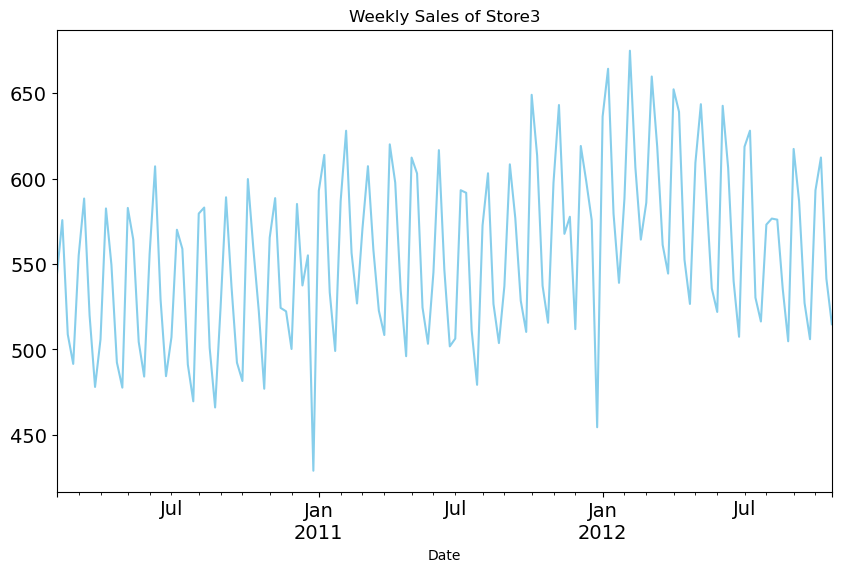

In [22]:
sales3.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store3', fontsize=14, color = 'skyblue')
plt.show()


<Figure size 640x480 with 0 Axes>

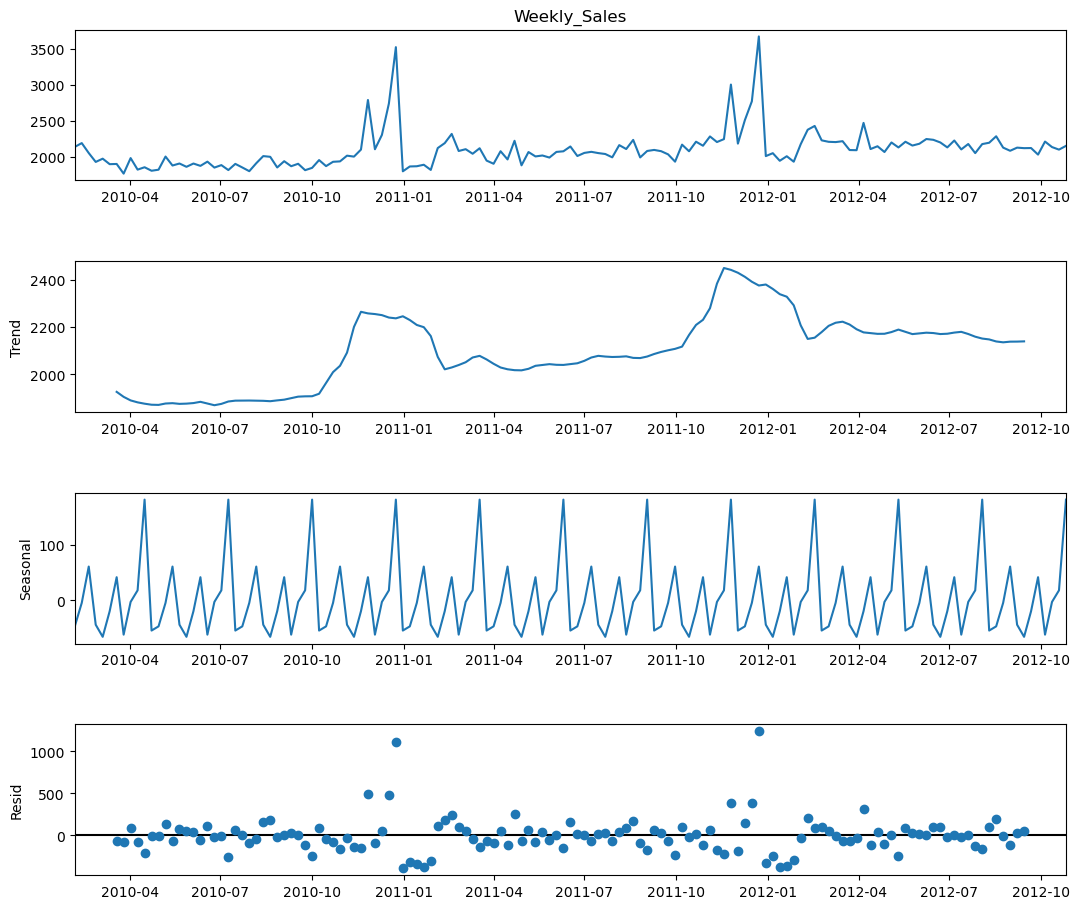

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

<Figure size 640x480 with 0 Axes>

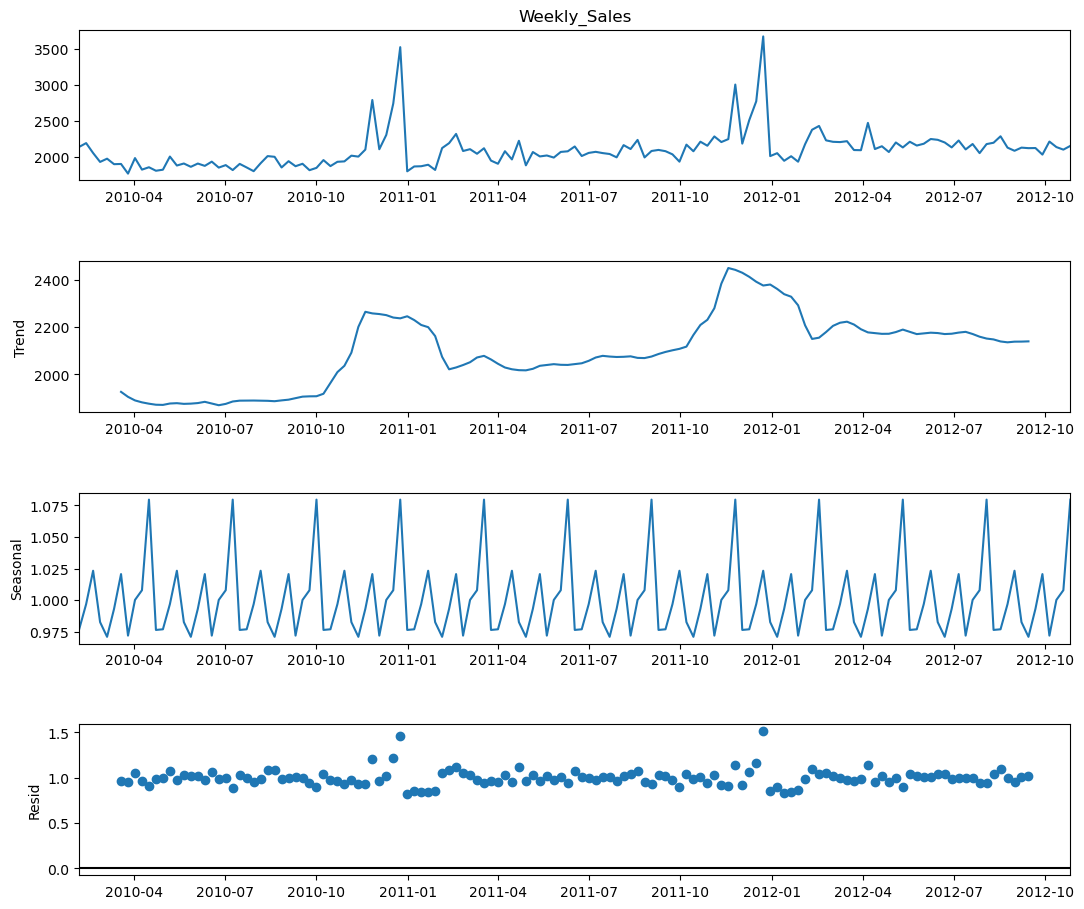

In [24]:
decomposition = seasonal_decompose(sales4.Weekly_Sales, model= 'multiplicative', period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [25]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales
y3=sales3.Weekly_Sales
y4=sales1.Weekly_Sales

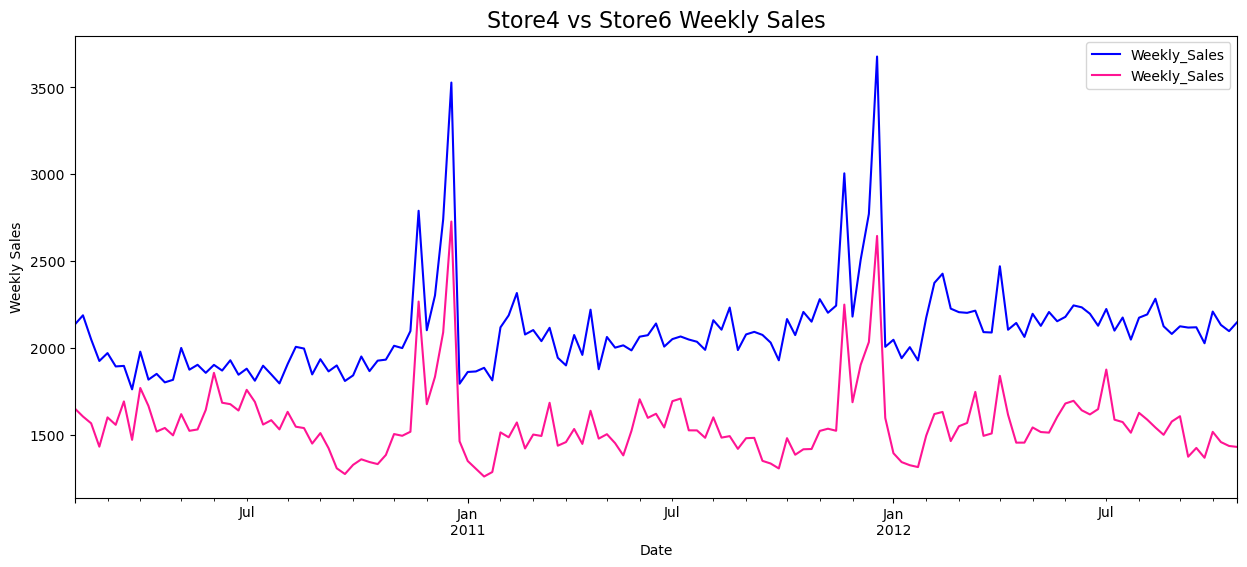

In [26]:
y1.plot(figsize=(15, 6), legend=True, color = 'blue')
y2.plot(figsize=(15, 6), legend=True, color = 'deeppink')

plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

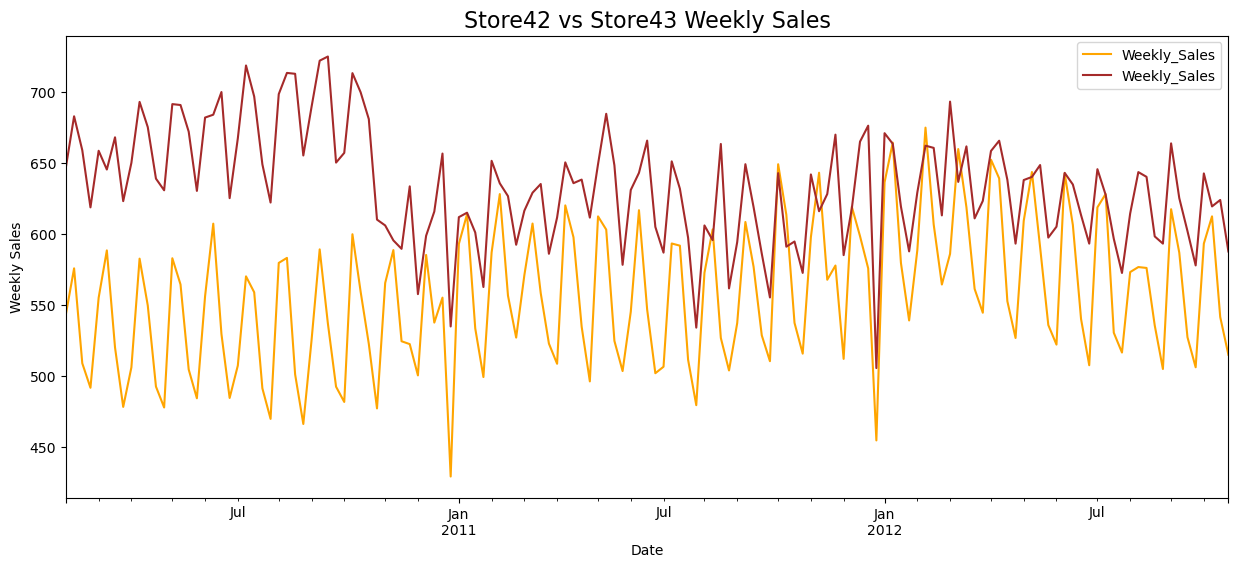

In [27]:
y3.plot(figsize=(15,6),legend=True, color= 'orange')
y4.plot(figsize=(15,6),legend=True, color= 'brown')

plt.ylabel('Weekly Sales')
plt.title('Store42 vs Store43 Weekly Sales', fontsize = '16')
plt.show()

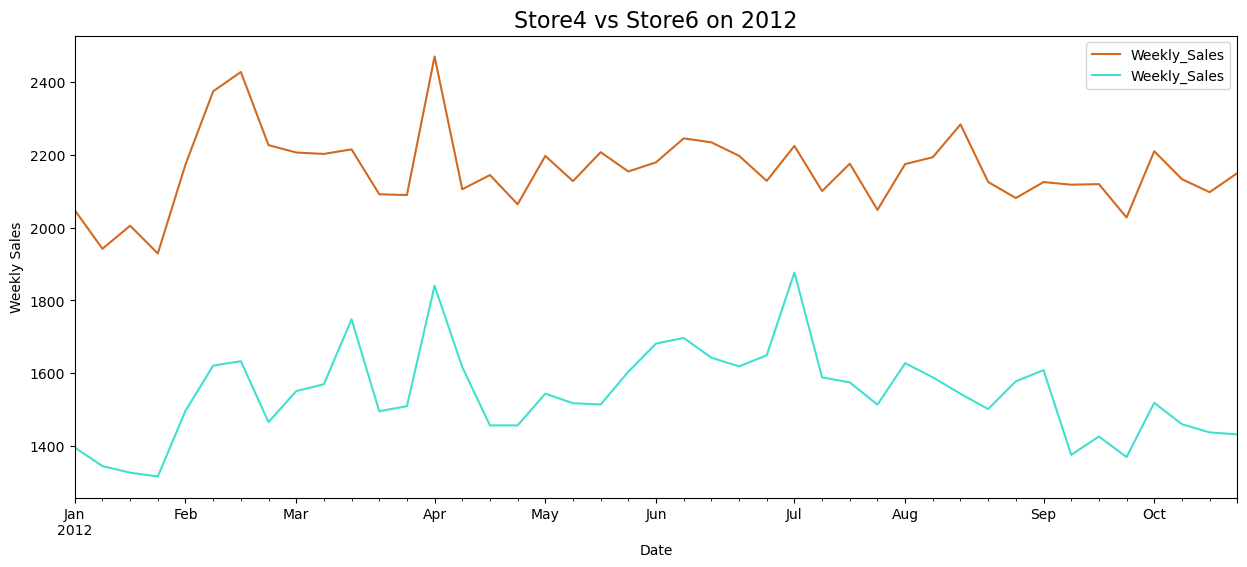

In [28]:
# Lets Look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

In [29]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [30]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\Eeshan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Eeshan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Eeshan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1032      0.105    -20.066      0.000      -2.309      -1.898
ar.L2         -1.9544      0.222     -8.800      0.000      -2.390      -1.519
ar.L3         -1.2199      0.247     -4.942      0.000      -1.704      -0.736
ar.L4         -0.4435      0.121     -3.670      0.000      -0.680      -0.207
ma.L1         -1.0514      0.537     -1.958      0.050      -2.104       0.001
ma.L2         -0.8474      0.166     -5.095      0.000      -1.173      -0.521
ma.L3          0.9100      0.543      1.675      0.094      -0.155       1.975
ar.S.L52      -0.1731      0.179     -0.967      0.334      -0.524       0.178
sigma2      1.401e+04   7400.893      1.893      0.058    -496.095    2.85e+04


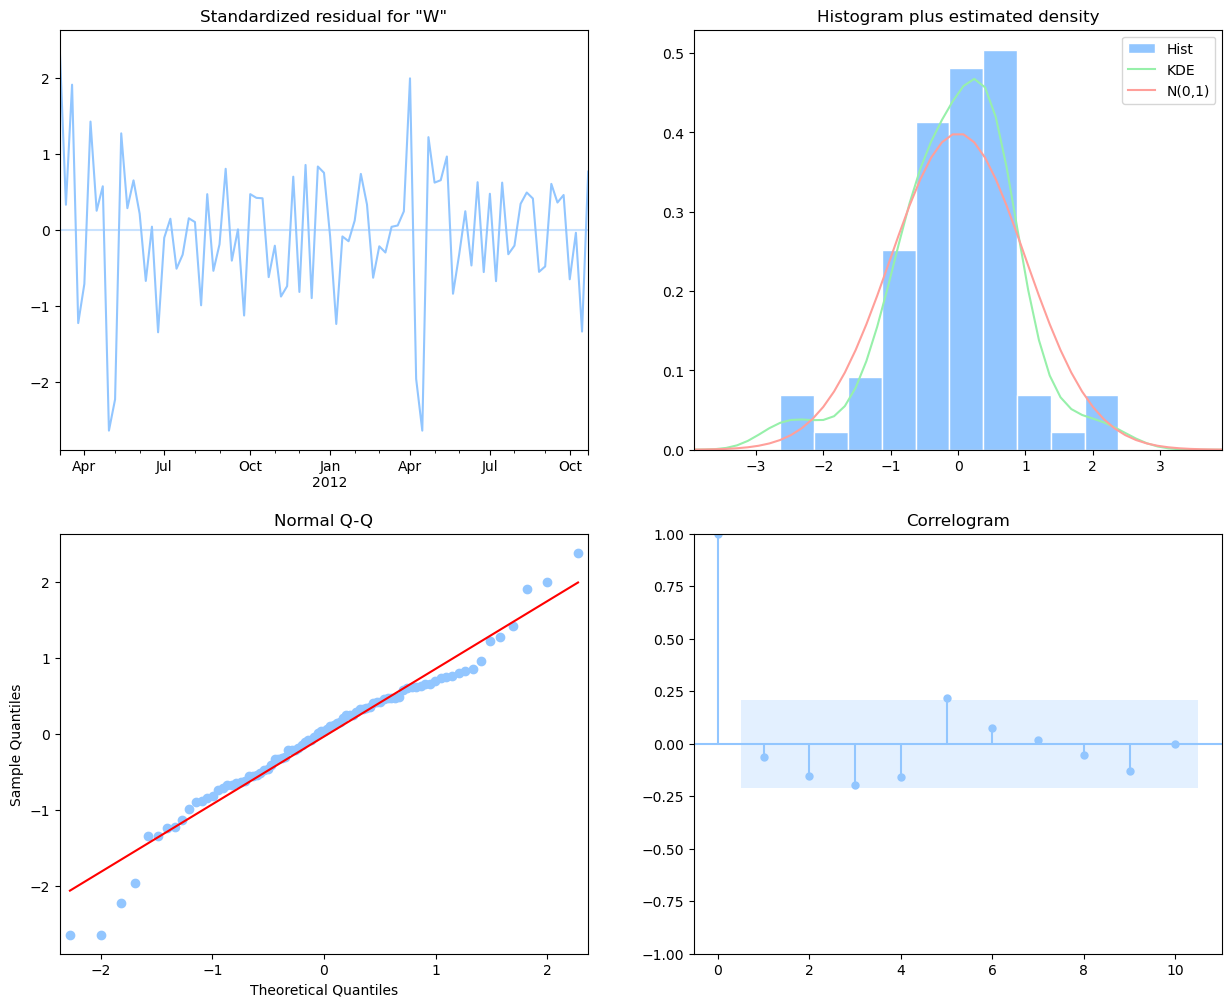

In [31]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [32]:
# Will predict for last 90 days. So setting the date according to that
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

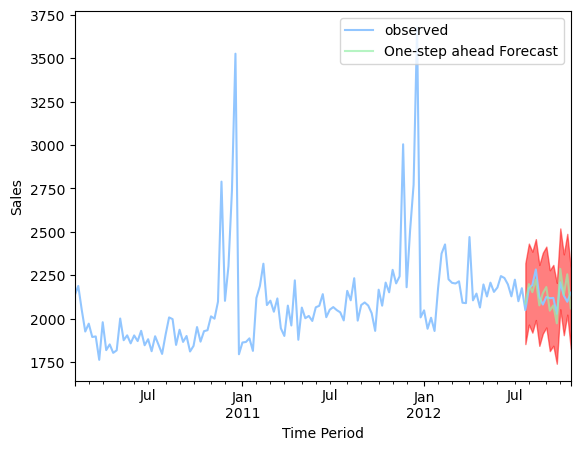

In [33]:


ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()



In [34]:


y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))



The Mean Squared Error of our forecasts is 4742.66


In [35]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

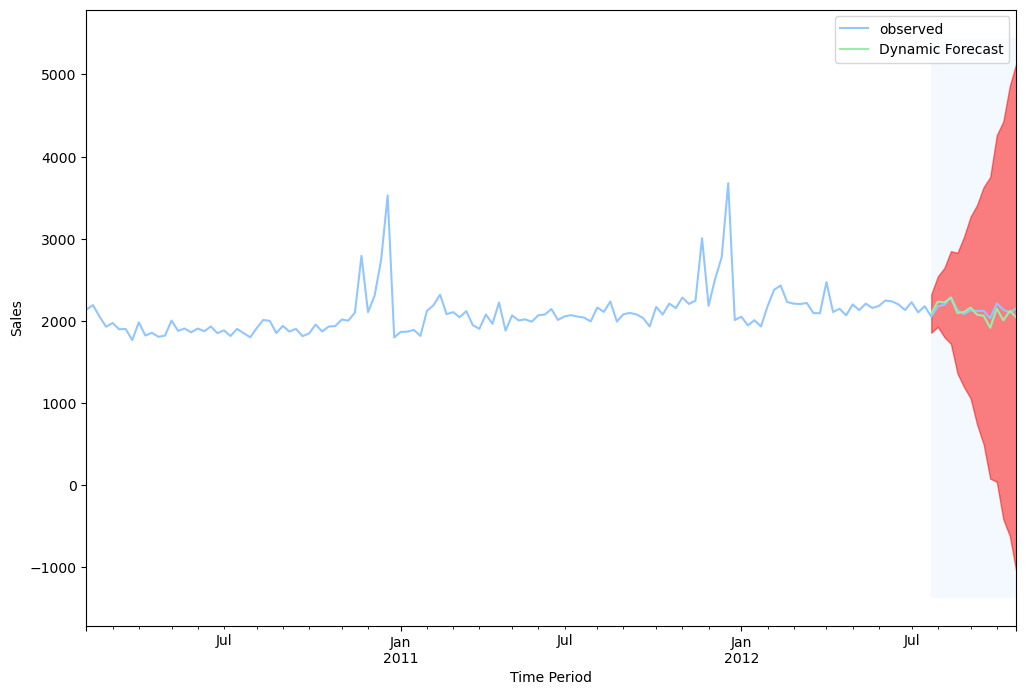

In [36]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='r', alpha=.5)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [37]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

y_truth = y1['2012-7-27':]

# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 66.17


In [38]:


Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())



Residual for Store1 763.79417456893


In [39]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

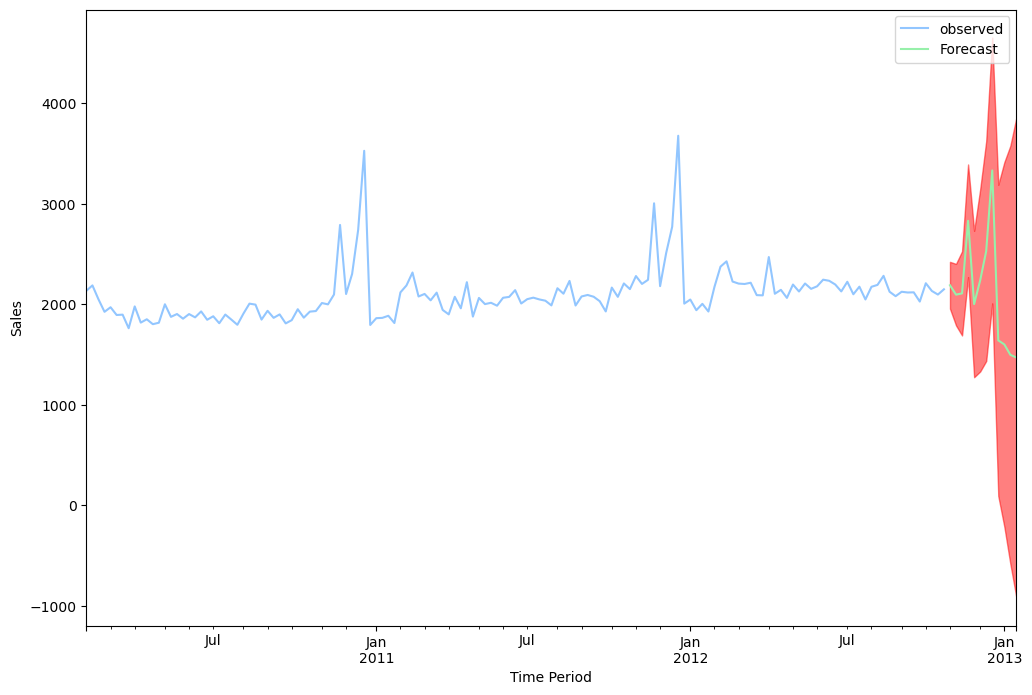

In [40]:
ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.50)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()


In [41]:
data["Weekly_Sales"]=data.Weekly_Sales/1000
data.head()

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Month,Year,Week
0,1,2010-02-05,1643.69090,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,5,Feb,2010,5
1,1,2010-02-12,1641.95744,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,12,Feb,2010,6
2,1,2010-02-19,1611.96817,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,19,Feb,2010,7
3,1,2010-02-26,1409.72759,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0,26,Feb,2010,8
4,1,2010-03-05,1554.80668,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0,5,Mar,2010,9


MODELLING AND ML

In [42]:
# create dummy variables for 'Type' and keeping all columns to see heatmap then will drop 1 column
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

# Not dropping the orginal Type column now so that I can use the field in some data analysis 

In [43]:
#Create a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)



In [44]:
# Lets look the correlation matrix and heat map of the 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='magma')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

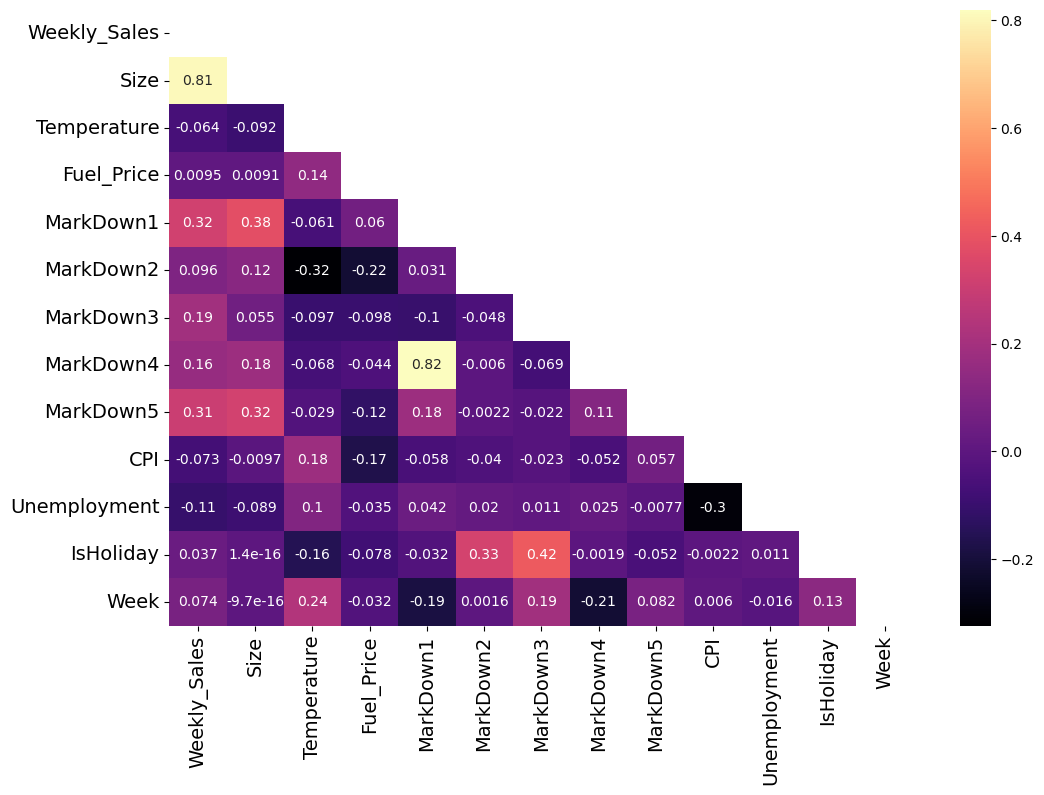

In [45]:
correlation_heat_map(data_heatmap_df)

#inference: By checking the direct correlation of features there is no much promising correlations. 
#           There are no much correlation within the features as well. In a way this is good because 
#           there won't be multicollinearity that we have to take care while running models.

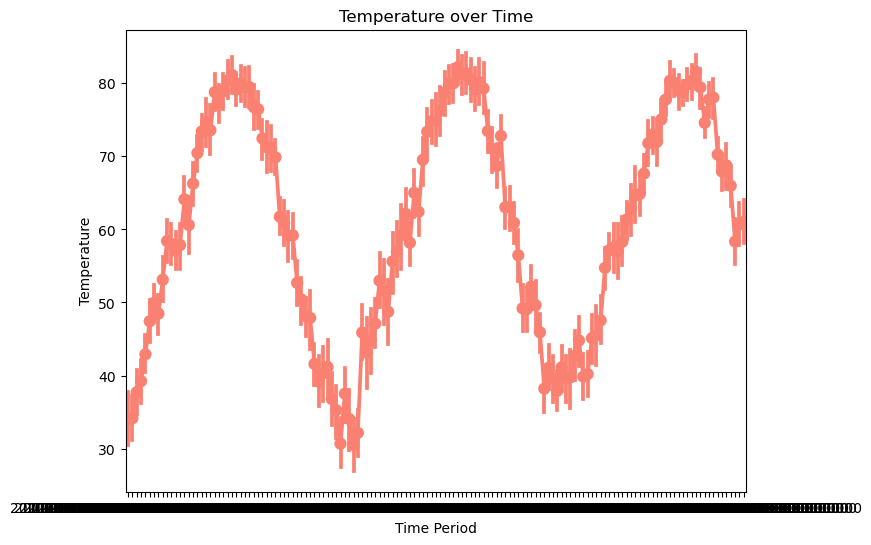

In [46]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()
# inference: Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would 
# be an interesting data point that we can use for studies further

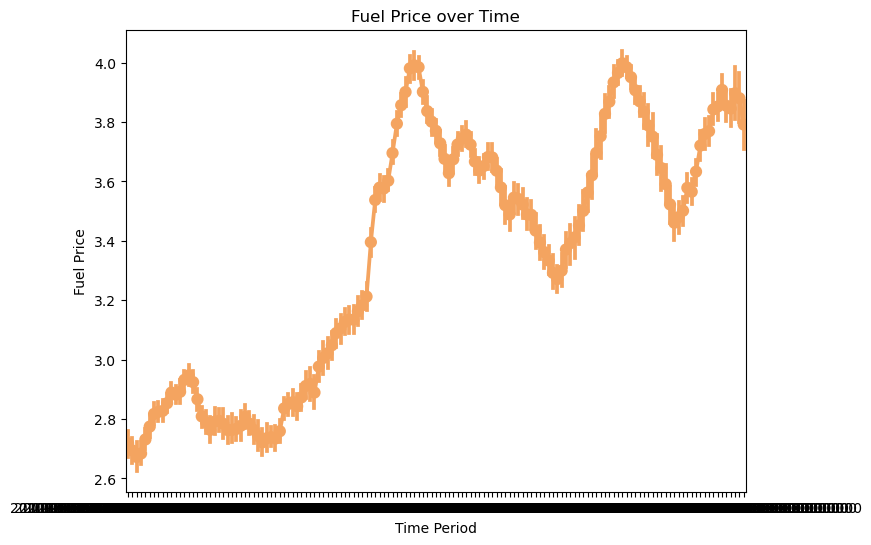

In [47]:


plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()
# inference: Fuel price varies over time and there are high and lows



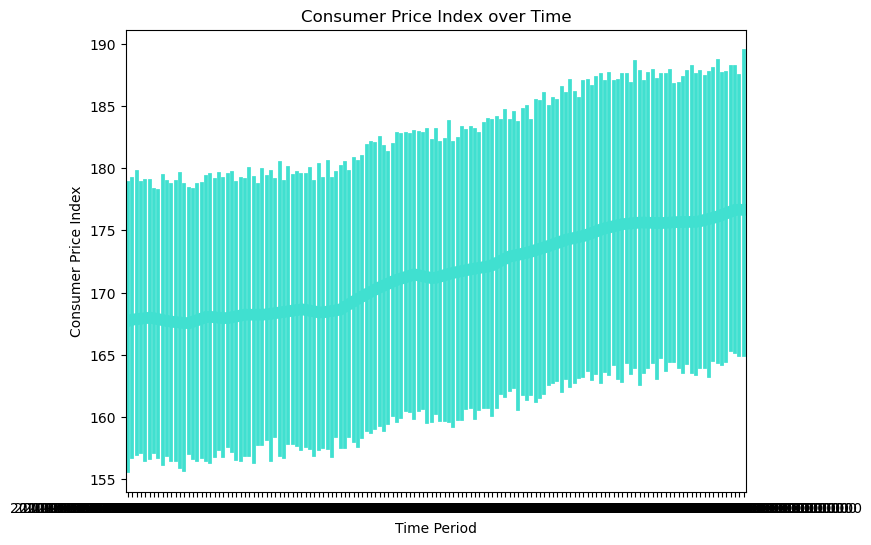

In [48]:


plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()
# inference: over time CPI have increased. but the change is not much



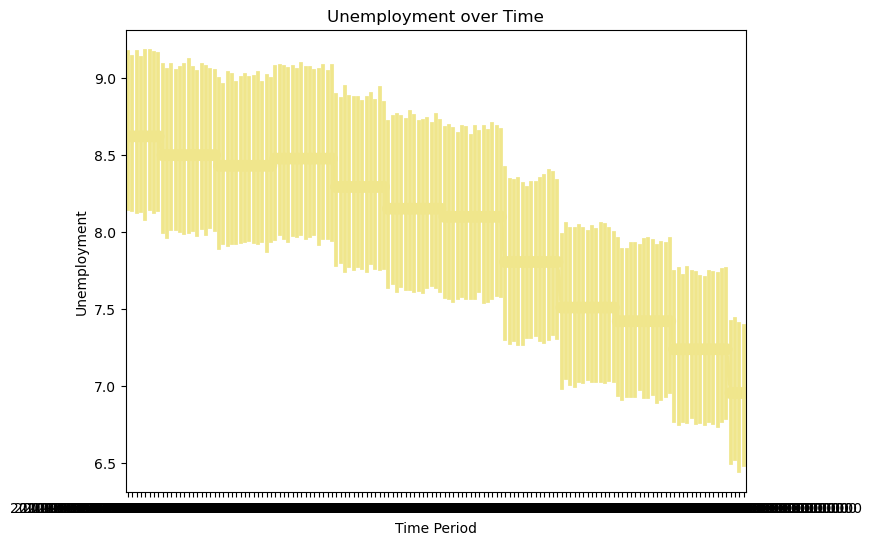

In [49]:


plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()
# inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales



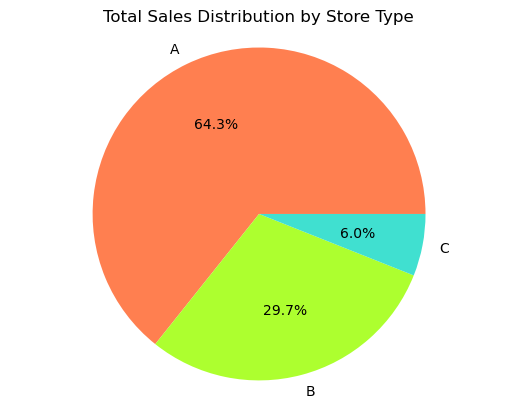

In [50]:
import matplotlib.pyplot as plt

# Calculate the sum of weekly sales for each store type
sales_sum = data.groupby('Type')['Weekly_Sales'].sum()
col = ['coral', 'greenyellow', 'turquoise']
# Create a pie chart
plt.pie(sales_sum, labels=sales_sum.index, autopct='%1.1f%%', colors=col)
plt.title('Total Sales Distribution by Store Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()


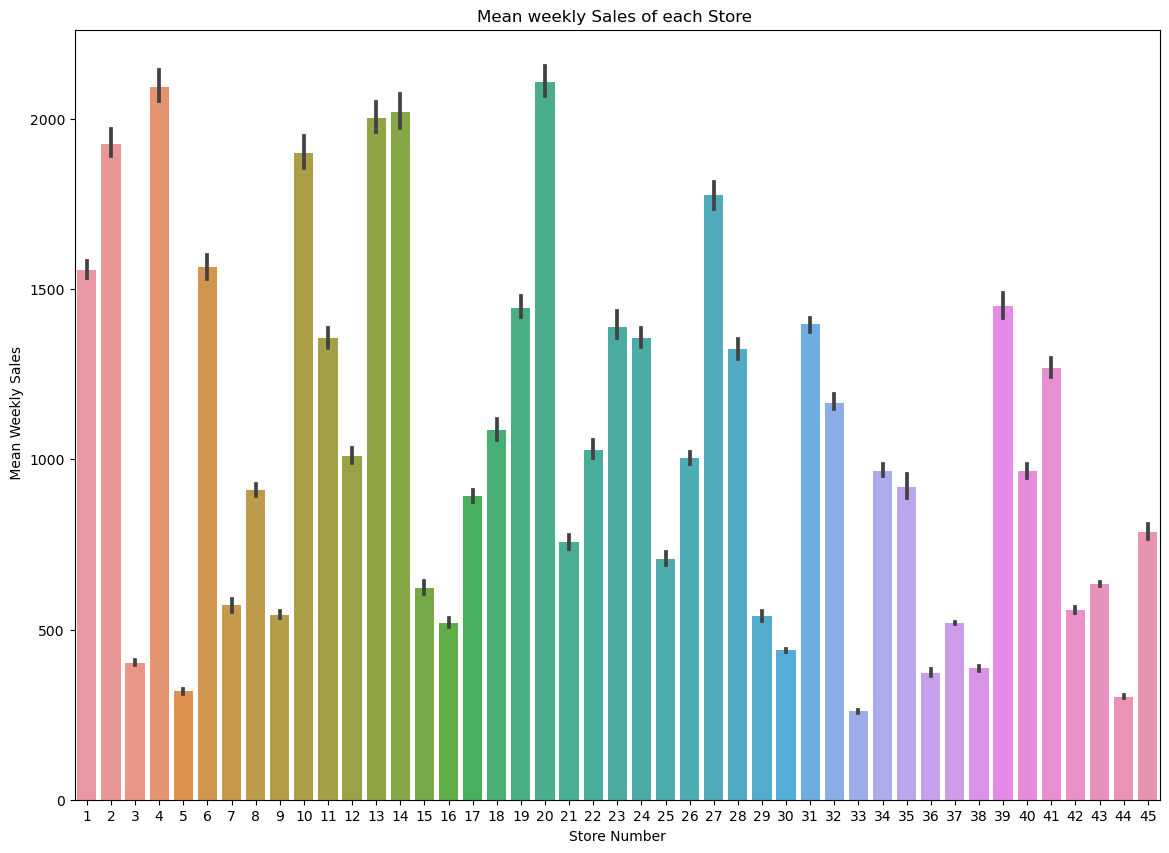

In [51]:
plt.subplots(figsize=(14,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

# inference : From the chart we can see that there are stores that have a weekly sales from $250,000  
#             to $2,200,000

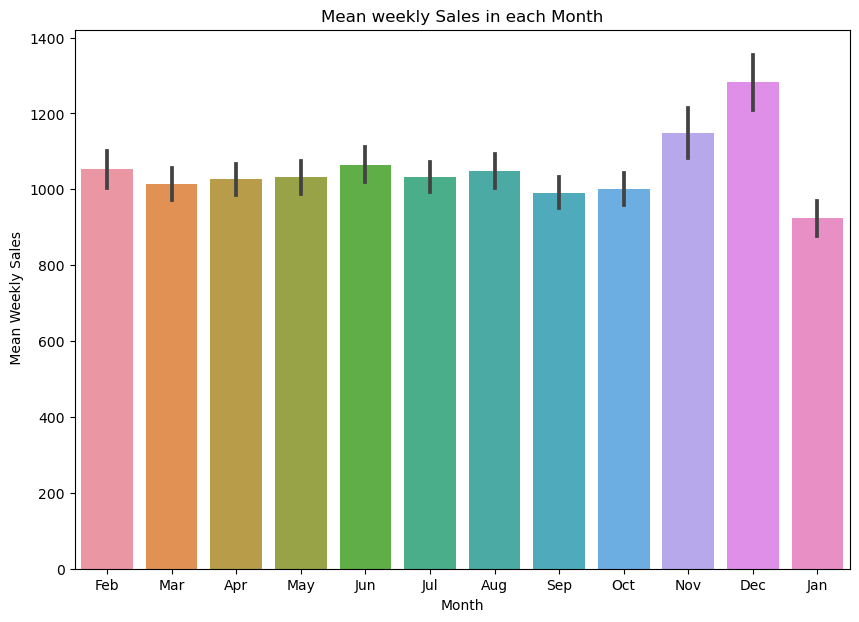

In [52]:


plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Months.png')
plt.show()
# inference: Graph shows sales in each month and from this we can see December seems to have a very high sales 
#            compared to every other month and January have the least sales. 



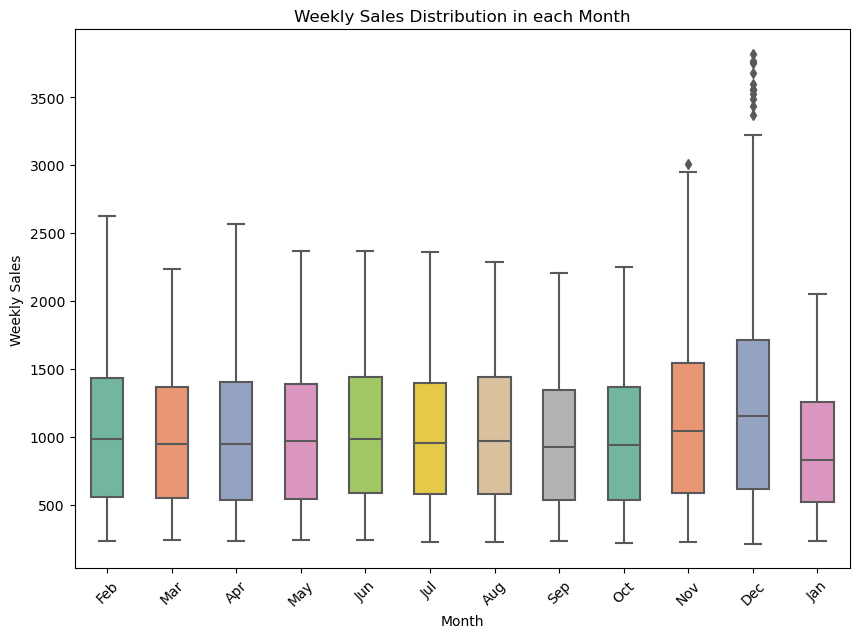

In [53]:
plt.subplots(figsize=(10, 7))
sns.boxplot(x="Month", y="Weekly_Sales", data=data, orient='v', width=0.5, palette='Set2')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Distribution in each Month')
plt.xticks(rotation=45)

plt.show()


feature engineering

In [54]:
# Create Week column which says which week of the month it is. 
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns that are required for later studies
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [55]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))



In [56]:


# Drop the columns that we have created dummies
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True) 

data#isna().sum().sort_values(ascending=False)

,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_Oct,Month_Sep,Year_2010,Year_2011,Year_2012,Week_1.0,Week_2.0,Week_3.0,Week_4.0,Week_5.0
0,2010-02-05,1643.69090,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,0,0
1,2010-02-12,1641.95744,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0
2,2010-02-19,1611.96817,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,0,0
3,2010-02-26,1409.72759,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0
4,2010-03-05,1554.80668,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,2012-09-28,713.17395,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,...,0,1,0,0,1,0,0,0,1,0
6431,2012-10-05,733.45507,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,...,1,0,0,0,1,1,0,0,0,0
6432,2012-10-12,734.46436,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,...,1,0,0,0,1,0,1,0,0,0
6433,2012-10-19,718.12553,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,...,1,0,0,0,1,0,0,1,0,0


In [57]:
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 

In [58]:
data.iloc[:,5:10].describe().T

# Inference: more than 50% is missing values with (-500) so imputing with KNN might not be a good idea. 
# But what are the other methods? imputing with random values in the range of that particular columns?
# Lets try that first.

,count,mean,std,min,25%,50%,75%,max
MarkDown1,2280.0,6855.587430,8183.310015,0.27,1679.190,4972.59,8873.5825,88646.76
MarkDown2,1637.0,3218.965504,9268.082387,-265.76,37.200,187.04,1785.2900,104519.54
MarkDown3,2046.0,1349.853021,9287.242800,-29.10,4.700,22.70,99.9875,141630.61
MarkDown4,1965.0,3303.858142,6211.203947,0.22,483.270,1419.42,3496.0800,67474.85
MarkDown5,2295.0,4435.262240,5868.933325,135.16,1702.565,3186.52,5422.0800,108519.28


In [59]:
#data = data.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis =1)
data.isna().sum().sort_values(ascending=False).head(10)

MarkDown2    4798
MarkDown4    4470
MarkDown3    4389
MarkDown1    4155
MarkDown5    4140
Date            0
Store_37        0
Store_43        0
Store_42        0
Store_41        0
dtype: int64

In [60]:
data.MarkDown1=data.MarkDown1.map(lambda x: np.nan if x==-500 else x)
data.MarkDown2=data.MarkDown2.map(lambda x: np.nan if x==-500 else x)
data.MarkDown3=data.MarkDown3.map(lambda x: np.nan if x==-500 else x)
data.MarkDown4=data.MarkDown4.map(lambda x: np.nan if x==-500 else x)
data.MarkDown5=data.MarkDown5.map(lambda x: np.nan if x==-500 else x)

In [61]:


missing_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Not including our actual y(Weekly Sales) and Size of store for Markdown since by including weekly sales
# It can be a bad method to use those MarkDown again for predicting weekly sales. 

impute_cols = [c for c in data.columns if not c in ['Weekly_Sales','Date','Sqrt_Sales','lnSales']+missing_cols]

data_imputed=data.copy()

data_imputed.isna().sum().sort_values(ascending=False).head(10)

MarkDown2    4798
MarkDown4    4470
MarkDown3    4389
MarkDown1    4155
MarkDown5    4140
Date            0
Store_37        0
Store_43        0
Store_42        0
Store_41        0
dtype: int64

In [62]:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print ("Best R2 value:",np.max(r2s),"\nBest k: ",np.argmax(k_range))
    return np.argmax(k_range)

In [63]:
impute_missing = data.loc[data.MarkDown1.isnull(), :]
impute_valid = data.loc[~data.MarkDown1.isnull(), :]

y = impute_valid.MarkDown1.values
X = impute_valid[impute_cols]

Xs = ss.fit_transform(X)

Best R2 value: 0.14140639091506765 
Best k:  25


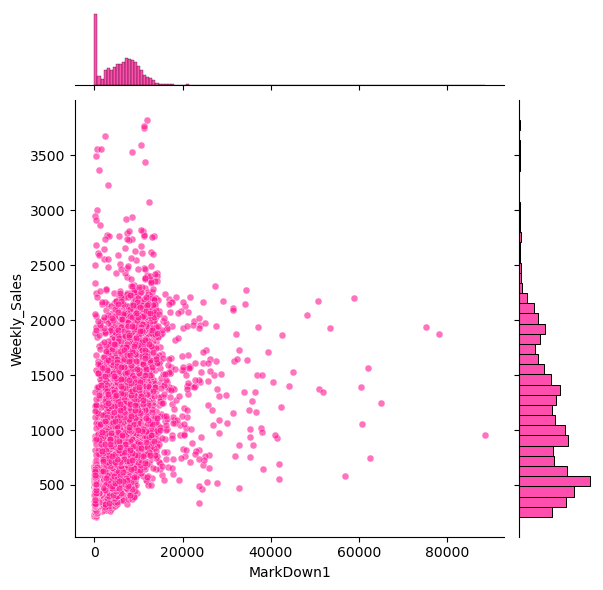

In [64]:
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown1_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown1.isnull(), 'MarkDown1'] = MarkDown1_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown1, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color='deeppink')
plt.show()

Best R2 value: 0.41503402148479146 
Best k:  25


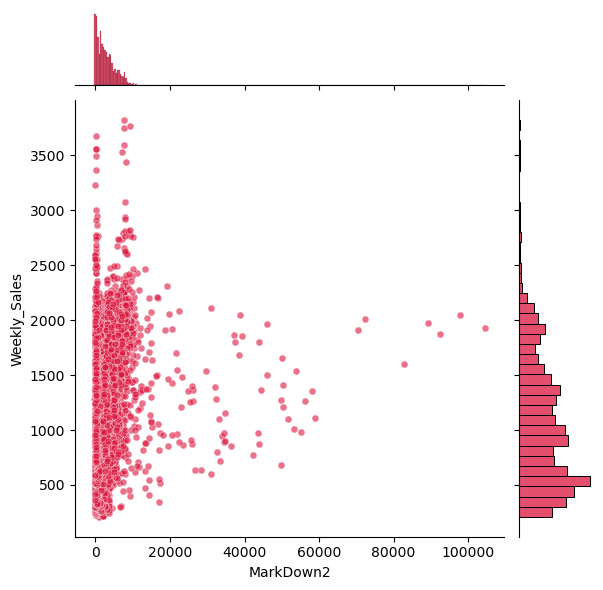

In [65]:
impute_missing = data.loc[data.MarkDown2.isnull(), :]
impute_valid = data.loc[~data.MarkDown2.isnull(), :]

y = impute_valid.MarkDown2.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown2_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown2.isnull(), 'MarkDown2'] = MarkDown2_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown2, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'crimson')
plt.show()

Best R2 value: 0.20431863554303203 
Best k:  25


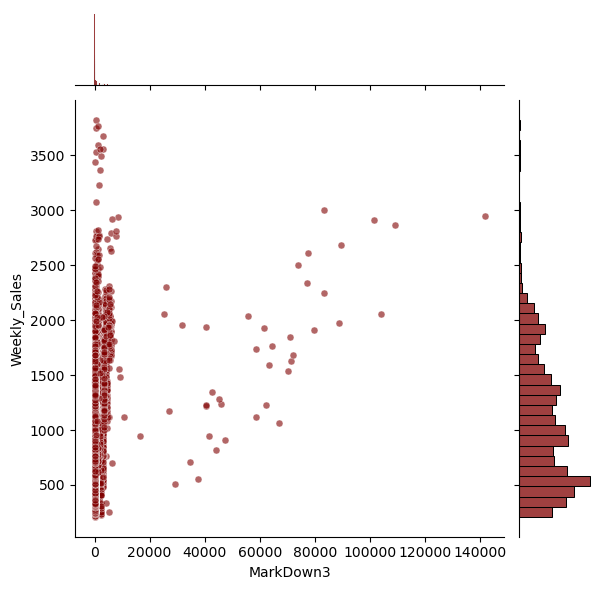

In [66]:
impute_missing = data.loc[data.MarkDown3.isnull(), :]
impute_valid = data.loc[~data.MarkDown3.isnull(), :]

y = impute_valid.MarkDown3.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown3_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown3.isnull(), 'MarkDown3'] = MarkDown3_impute

sns.jointplot(data_imputed.MarkDown3, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color= 'maroon')
plt.show()

Best R2 value: 0.3470822603116795 
Best k:  25


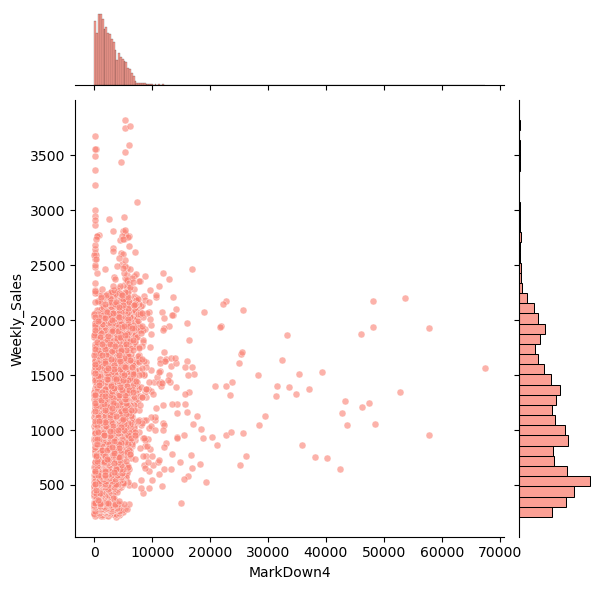

In [67]:
impute_missing = data.loc[data.MarkDown4.isnull(), :]
impute_valid = data.loc[~data.MarkDown4.isnull(), :]

y = impute_valid.MarkDown4.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown4_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown4.isnull(), 'MarkDown4'] = MarkDown4_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'salmon')
plt.show()

Best R2 value: 0.0815206539204145 
Best k:  25


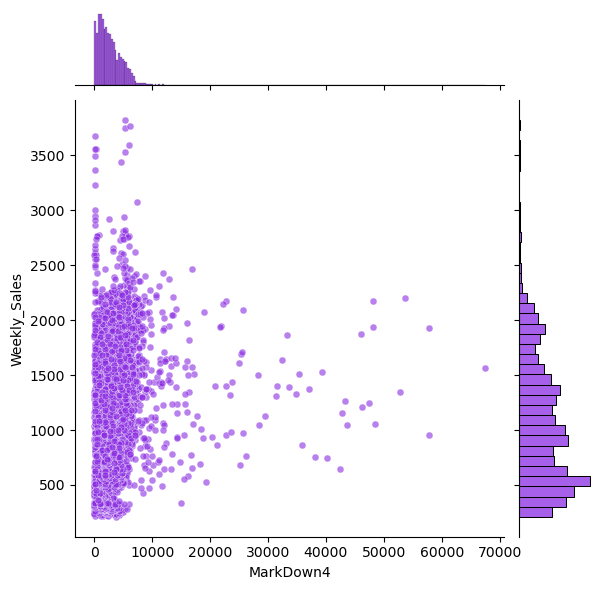

In [68]:
impute_missing = data.loc[data.MarkDown5.isnull(), :]
impute_valid = data.loc[~data.MarkDown5.isnull(), :]

y = impute_valid.MarkDown5.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown5_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown5.isnull(), 'MarkDown5'] = MarkDown5_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'blueviolet')
plt.show()

In [69]:
walmart_data=data_imputed.copy()

# The accuracy and R2 are very bad. This means that we likely imputing crap with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

In [70]:
data_imputed.isna().sum().sum()

0

modelling


In [71]:
# predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
# X=data_imputed[predictors]
# y=data_imputed.Weekly_Sales.values 
# Xs = ss.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)


0.9373047868585271
0.9475387792996036
Adjusted R^2 0.9365753142527931
Cross-validated scores: [0.95779325 0.9385447  0.94587317 0.9417496  0.93029786 0.94698379
 0.95945038 0.96490548 0.94890179 0.92138744]
Mean Cross validation 0.9455887464307601


Text(0.5, 1.0, 'Predicted vs Actual Sales')

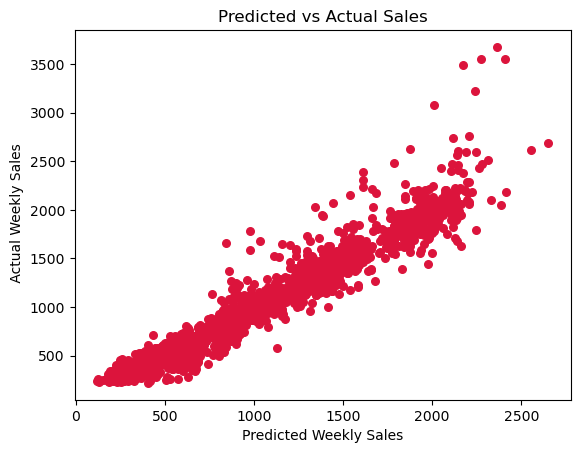

In [72]:
predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values 

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='crimson', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

0.9400371762791395
0.9395365507194454
Cross-validated scores: [ 7.00623668e-01 -9.25891710e+12 -6.38166896e+13 -1.77810531e+12
 -3.11582305e+13 -3.24914030e+12 -3.68092385e+13 -1.14405751e+14
 -5.42106780e+12 -4.82712152e+13]
Mean Cross validation -31416835548759.332


Text(0.5, 1.0, 'Predicted vs Actual Sales')

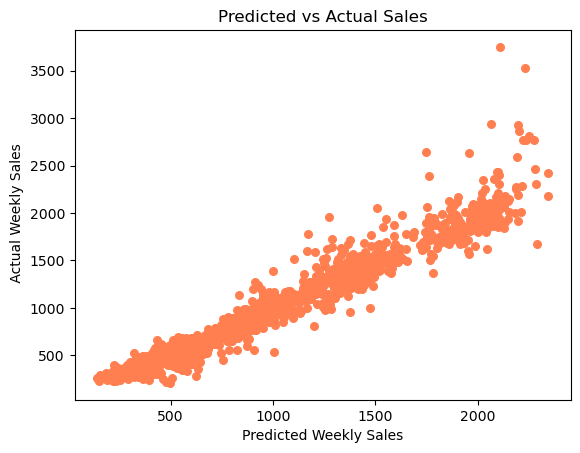

In [73]:
predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values 
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, color = 'coral', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

In [74]:

data = data_imputed.copy()

In [75]:


# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=data.Date.max()-offset
 

In [76]:

data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

In [77]:
data_train = data_train.reindex(np.random.permutation(data_imputed.index))## Identify outliers

In [78]:

# data_train = data_train.reindex(np.random.permutation(data.index))## Identify outliers
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 2415 to 3066
Data columns (total 76 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5850 non-null   datetime64[ns]
 1   Weekly_Sales  5850 non-null   float64       
 2   Size          5850 non-null   float64       
 3   Temperature   5850 non-null   float64       
 4   Fuel_Price    5850 non-null   float64       
 5   MarkDown1     5850 non-null   float64       
 6   MarkDown2     5850 non-null   float64       
 7   MarkDown3     5850 non-null   float64       
 8   MarkDown4     5850 non-null   float64       
 9   MarkDown5     5850 non-null   float64       
 10  CPI           5850 non-null   float64       
 11  Unemployment  5850 non-null   float64       
 12  IsHoliday     5850 non-null   float64       
 13  Type_A        5850 non-null   float64       
 14  Type_B        5850 non-null   float64       
 15  Store_2       5850 non-null   float

In [79]:
data_train.columns

Index(['Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type_A', 'Type_B', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9',
       'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15',
       'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21',
       'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27',
       'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33',
       'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'Year_2011', 'Year_2012', 'Week_1.0', 'Week_2.0',
       'Week_3

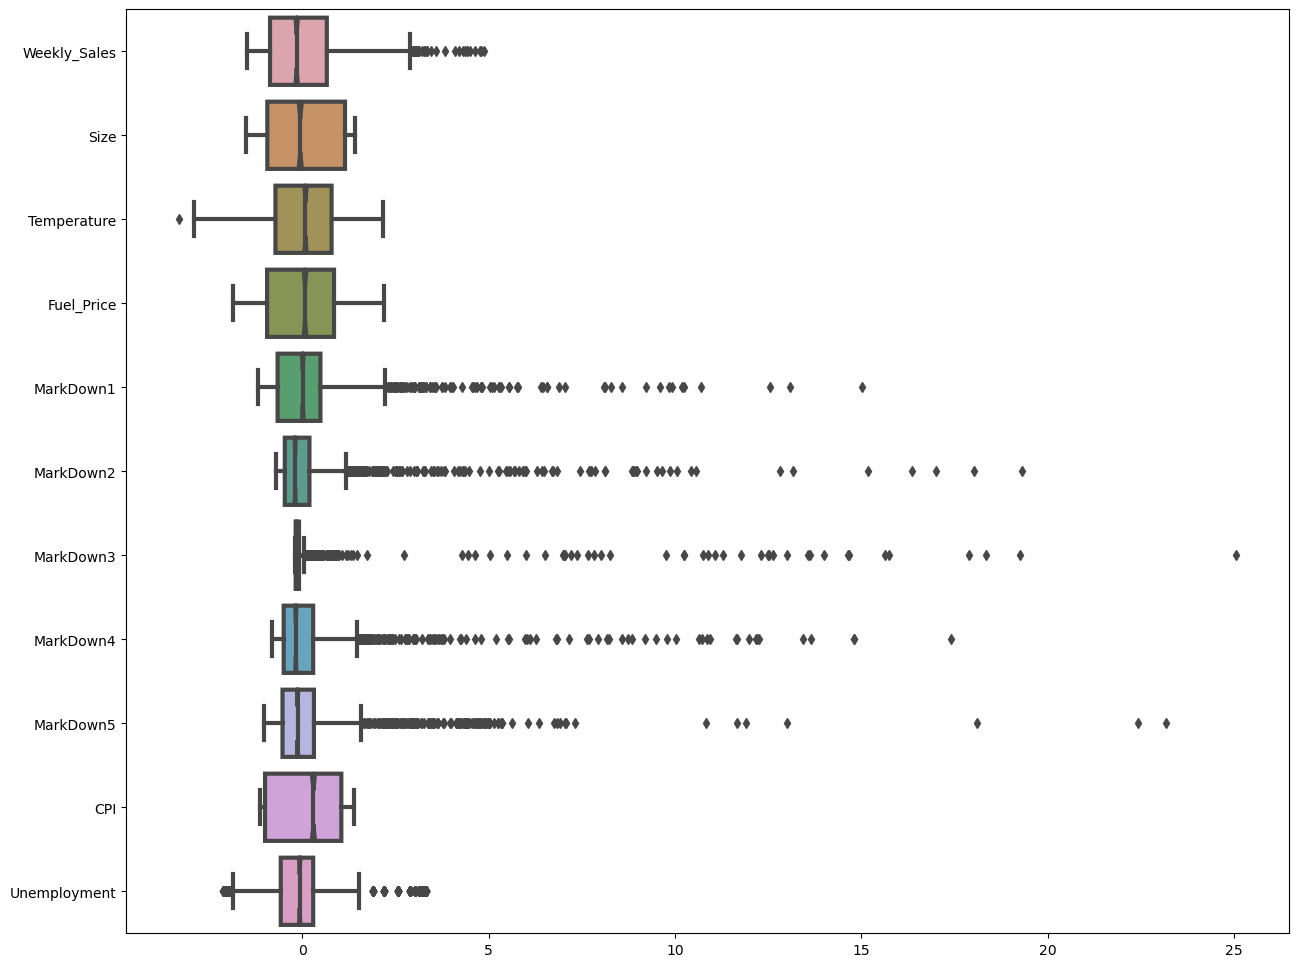

In [80]:
data_box=data_train.iloc[:, 1:12]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 12))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

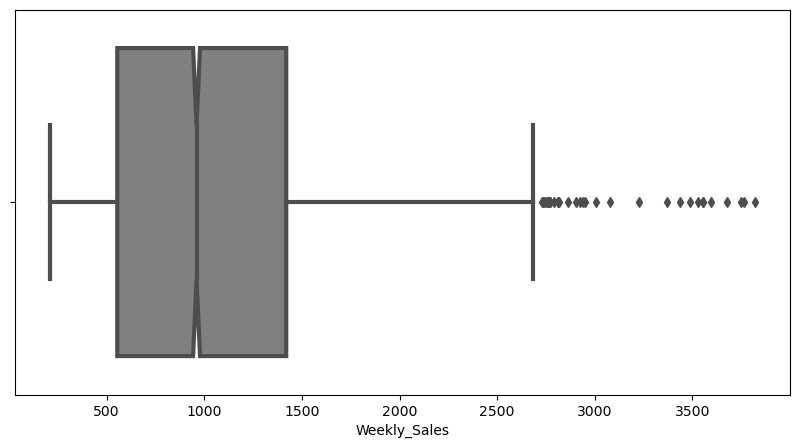

In [81]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'grey')
plt.show()

In [82]:
# Lets consider 3,000,000 as upper limit 

data_train[data_train.Weekly_Sales>3000].shape

(14, 76)

In [83]:
data_train=data_train[data_train.Weekly_Sales<3000]

feature selection

In [84]:


predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]

In [85]:
X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 2415 to 3066
Data columns (total 57 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Size          5836 non-null   float64
 1   Temperature   5836 non-null   float64
 2   Fuel_Price    5836 non-null   float64
 3   MarkDown1     5836 non-null   float64
 4   MarkDown2     5836 non-null   float64
 5   MarkDown3     5836 non-null   float64
 6   MarkDown4     5836 non-null   float64
 7   MarkDown5     5836 non-null   float64
 8   CPI           5836 non-null   float64
 9   Unemployment  5836 non-null   float64
 10  IsHoliday     5836 non-null   float64
 11  Type_A        5836 non-null   float64
 12  Type_B        5836 non-null   float64
 13  Store_2       5836 non-null   float64
 14  Store_3       5836 non-null   float64
 15  Store_4       5836 non-null   float64
 16  Store_5       5836 non-null   float64
 17  Store_6       5836 non-null   float64
 18  Store_7       5836 non-nu

In [86]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)

In [87]:
lgbm_features = lgb.LGBMRegressor()

In [88]:
lgbm_features.fit(X_train, y_train)

LGBMRegressor()

In [89]:


importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)



<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

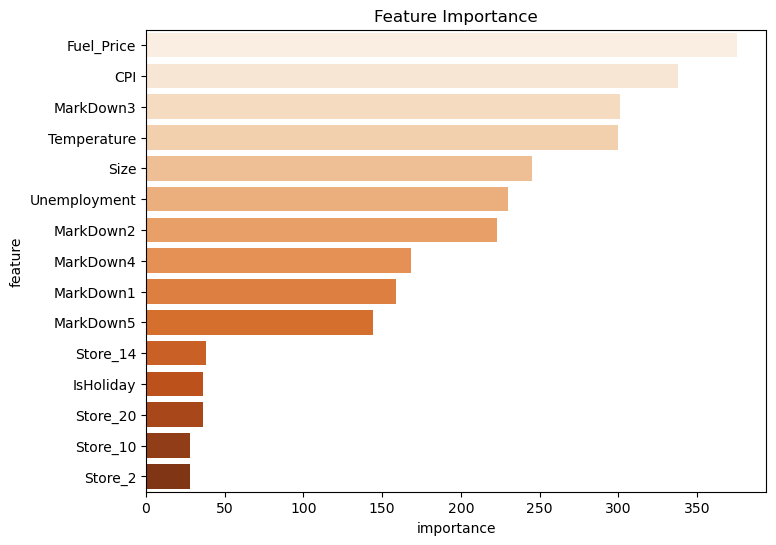

In [90]:
plt.figure(figsize=(8, 6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='Oranges')

lasso feature selection

In [91]:
print(X_train.shape)
X_train.info()

(5836, 57)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5836 entries, 2415 to 3066
Data columns (total 57 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Size          5836 non-null   float64
 1   Temperature   5836 non-null   float64
 2   Fuel_Price    5836 non-null   float64
 3   MarkDown1     5836 non-null   float64
 4   MarkDown2     5836 non-null   float64
 5   MarkDown3     5836 non-null   float64
 6   MarkDown4     5836 non-null   float64
 7   MarkDown5     5836 non-null   float64
 8   CPI           5836 non-null   float64
 9   Unemployment  5836 non-null   float64
 10  IsHoliday     5836 non-null   float64
 11  Type_A        5836 non-null   float64
 12  Type_B        5836 non-null   float64
 13  Store_2       5836 non-null   float64
 14  Store_3       5836 non-null   float64
 15  Store_4       5836 non-null   float64
 16  Store_5       5836 non-null   float64
 17  Store_6       5836 non-null   float64
 18  Store_7       

In [92]:


lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


LassoCV(cv=10, max_iter=2000, n_alphas=1000, verbose=1)

In [93]:


# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]



,feature,coef,abscoef
0,Size,347.440079,347.440079
11,Type_A,172.384215,172.384215
21,Store_10,131.966692,131.966692
19,Store_8,-98.376268,98.376268
51,Store_40,-92.706010,92.706010
43,Store_32,-89.647948,89.647948
44,Store_33,-85.179793,85.179793
20,Store_9,-77.209609,77.209609
52,Store_41,-77.163473,77.163473
45,Store_34,-75.254886,75.254886


In [94]:


importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)



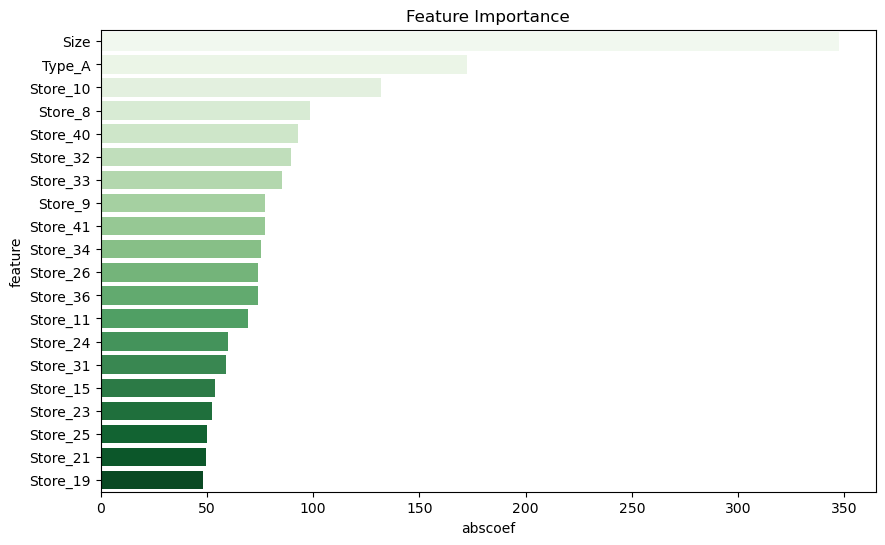

In [95]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lasso_feat.head(20), x='abscoef', y='feature', palette = 'Greens');

In [96]:


actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values



In [97]:


# Lets see the best alpha score
lasso_cv.alpha_

#best alpha value is 0.45384197291954748 which could be used later to run model

# 17.297005804454567


0.45384197291954803

In [98]:

# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)



Lasso(alpha=0.45384197291954803)

In [99]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.91573461 0.93288834 0.93157909 0.9447937  0.93777198 0.93988268
 0.93545696 0.93609943 0.93037953 0.93085471]
0.9335441008226851


In [100]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.9602241138737961
Adjusted R2:  0.9559219781827266


In [101]:
# converting the residuals into the actual dimenssion

train_resids = y_train*1000 - best_lasso.predict(X_train_s)*1000
test_resids = y_test*1000 - lasso_yhat*1000
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big 
# and in terms of millions

Train Residual 500899948.5893171
Test Residual 39751906.32790469
Residual ratio of Test to Train 0.07936097106789061


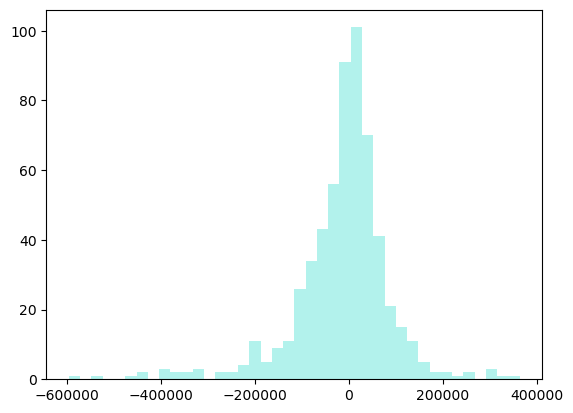

In [102]:


sns.distplot(test_resids, kde=False, bins=40, color = 'turquoise')
plt.show()

# The residuals looks ok and almost like a normal distribution



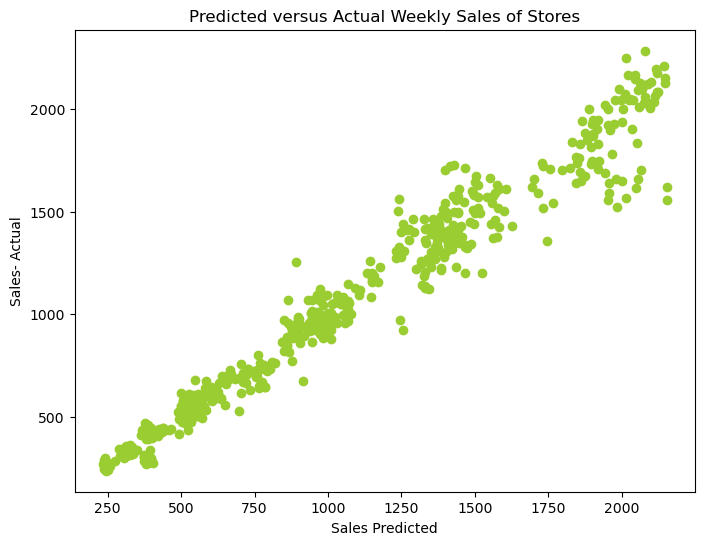

In [103]:


fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test, c='yellowgreen')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
#plt.savefig('./images/Actual_vs_Predicted_Sales.png')
plt.show()



In [104]:


X_train = X_train[actual_predictors]
X_test = X_test[actual_predictors]

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)



final model selection & implemtation

In [105]:


rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')



In [106]:


# Fit and crossvalidate on train data
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)



0.9509022077917895

In [107]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.7952107510448927
Adjusted R2:  0.7747703928629328


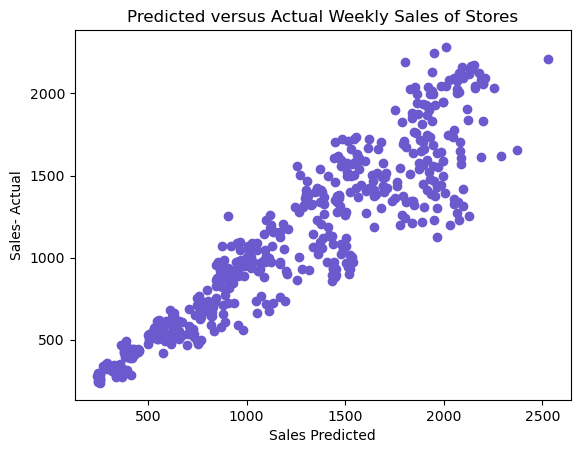

In [108]:


plt.scatter(rfr_yhat, y_test, color='slateblue')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()



In [109]:


train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - rfr_yhat*1000
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())



Train Residual 150123019.82219985
Test Residual 91368640.3597
Residual ratio of Test to Train 0.6086251160409218


In [110]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)

In [111]:


gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)



0.9515690564650784

In [112]:


gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)



R2:  0.7746060629327289
Adjusted R2:  0.7521091162951294


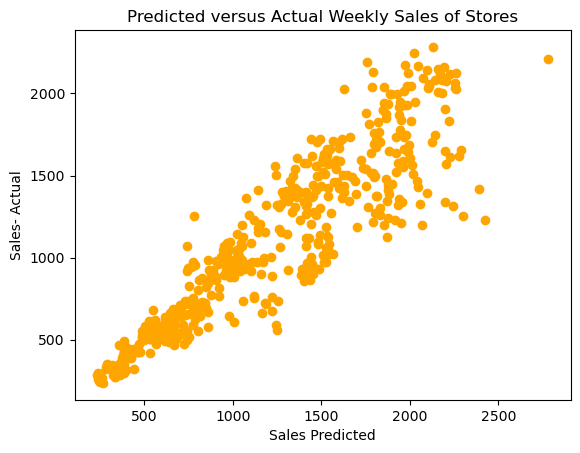

In [113]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [114]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 70612589.50101233
Test Residual 94632648.63057867
Residual ratio of Test to Train 1.3401668073541189


In [115]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

SVR(C=50000.0, max_iter=500)

In [116]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=10)
np.mean(svr_scores)

0.5273994377084434

In [117]:
svr_yhat=svr.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  0.40465210542667096
Adjusted R2:  0.34522943421690366


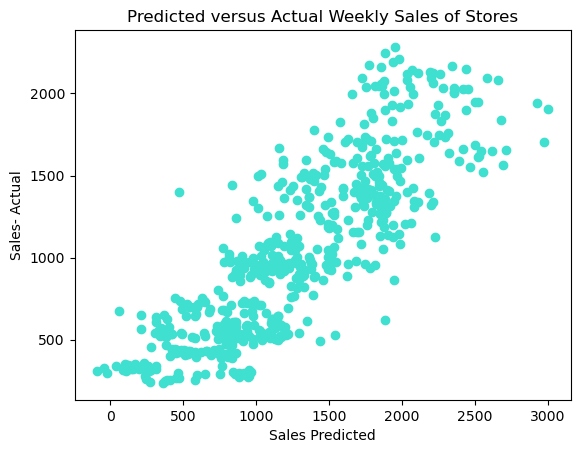

In [118]:
plt.scatter(svr_yhat, y_test, c='turquoise')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [119]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - svr_yhat*1000
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual", np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 150123019.82219985
Test Residual 192235311.08143038
Residual ratio of Test to Train 1.2805185461170896


In [120]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x  

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [121]:
# Setting the size of bubble according to the percentage change in prediction
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

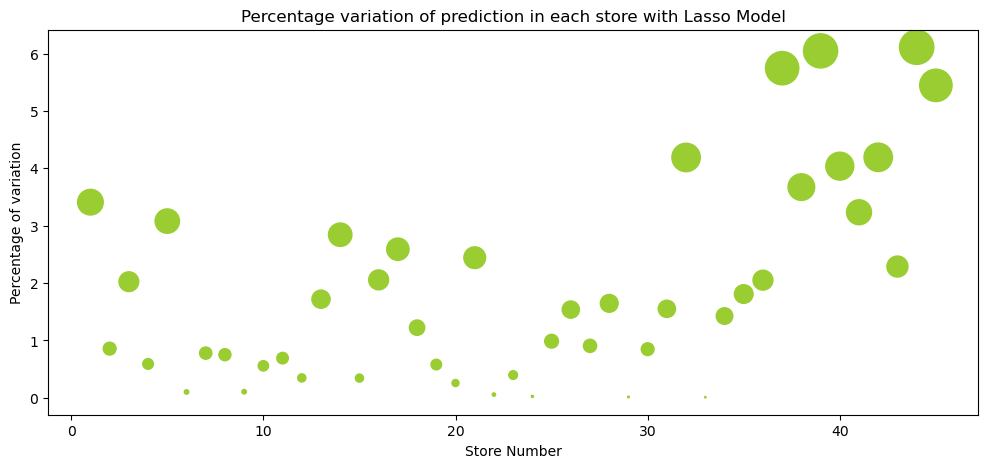

In [122]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s, color = 'yellowgreen')
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
#plt.savefig('./images/percentage_prediction_variation.png')
plt.show()

In [123]:


# Create a dataframe to compare different models
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score)
Score["Adj_R2"]=(lasso_adj_r2,rfr_adj_r2,gb_adj_r2)
Score["Test_Residual"]=(lasso_residue,rfr_residue,gb_residue)



insights / conclusions


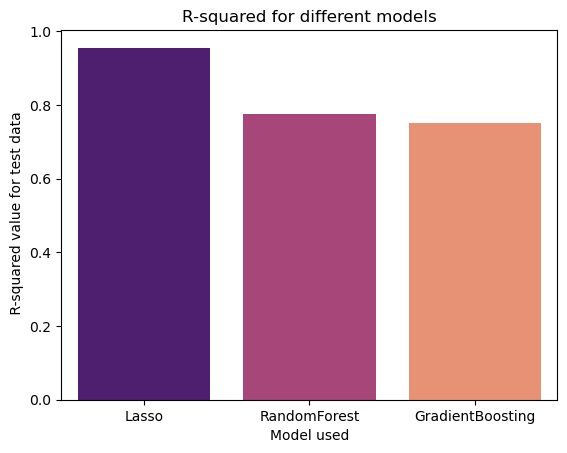

In [124]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Model_Name", y="Adj_R2", data=Score,orient='v', palette='magma')
plt.xlabel('Model used')
plt.ylabel(' R-squared value for test data')
plt.title('R-squared for different models')
#plt.savefig('./images/R2_for_different_models.png')
plt.show()

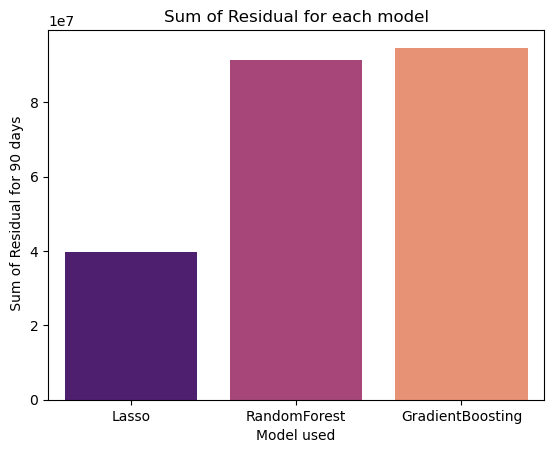

In [125]:
sns.barplot(x="Model_Name", y="Test_Residual", data=Score,orient='v', palette='magma')
plt.xlabel('Model used')
plt.ylabel(' Sum of Residual for 90 days')
plt.title('Sum of Residual for each model')
#plt.savefig('./images/Residual_for_different_models.png')
plt.show()

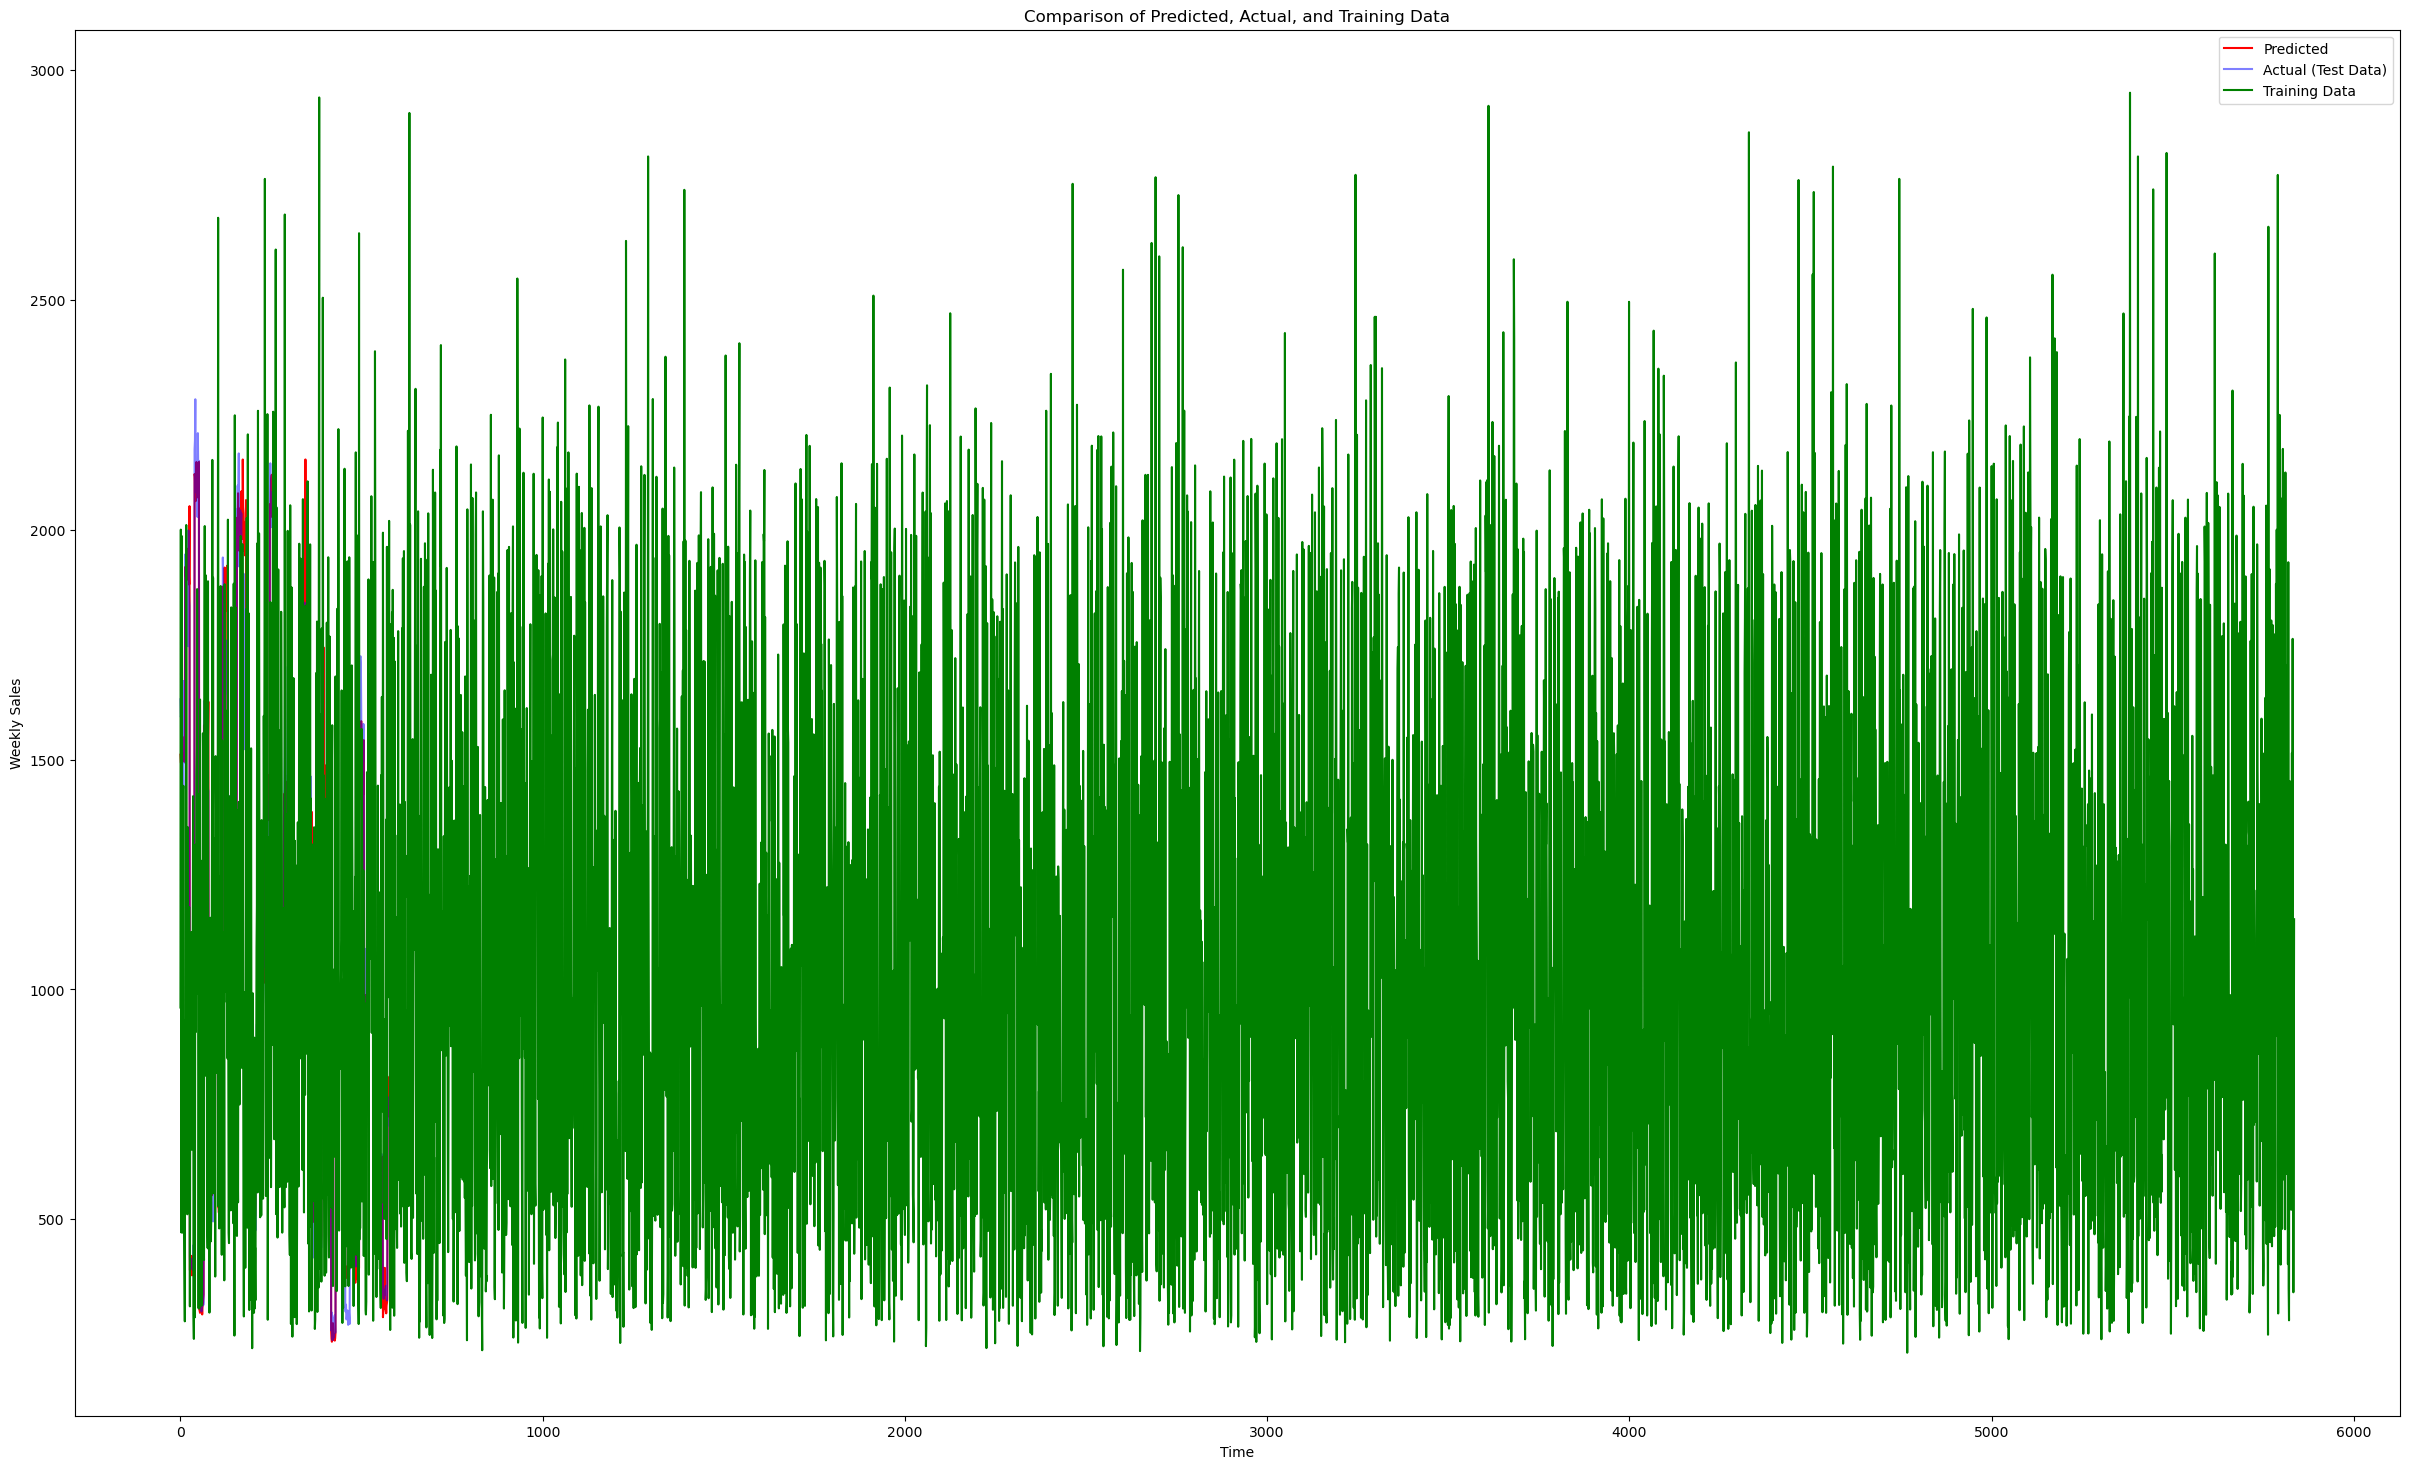

In [129]:
# Plotting parameters
plt.figure(figsize=(30, 18))  # Adjust the figure size as needed

# Plot the predicted values
plt.plot(lasso_yhat, color='red', label='Predicted')

# Plot the actual values (test data)
plt.plot(y_test, color='blue', label='Actual (Test Data)')

# Plot the training data
plt.plot(y_train, color='green', label='Training Data')

# Set the x-axis label and title
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted, Actual, and Training Data')

# Add a legend
plt.legend()

# Show the plot
plt.show()


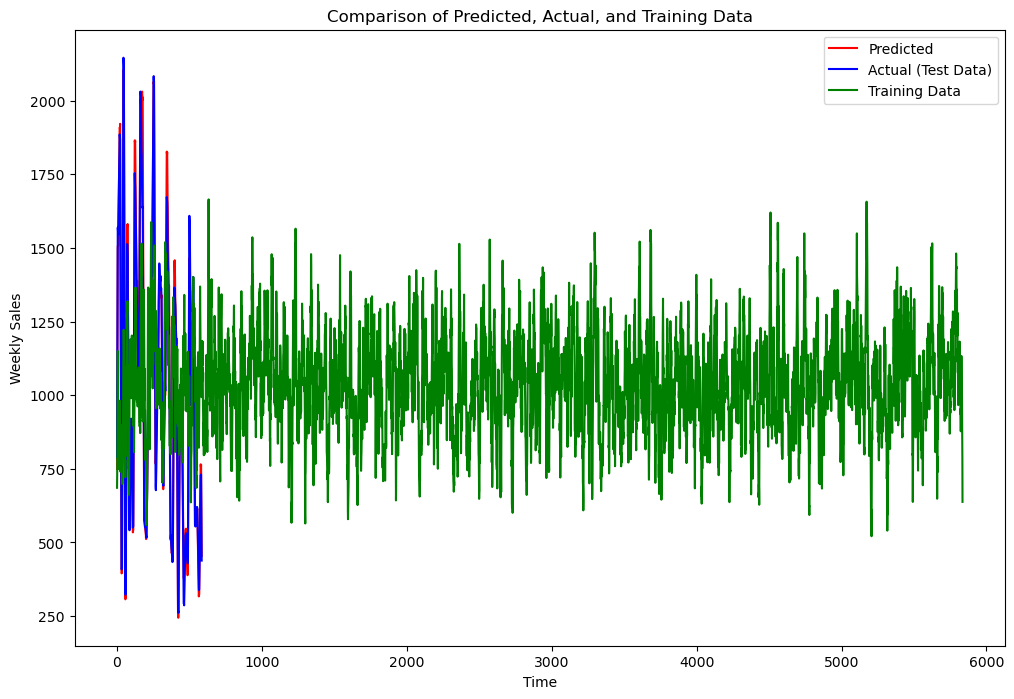

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting parameters
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

# Smooth the lines using a rolling mean with window size 10
window_size = 10
lasso_yhat_smoothed = np.convolve(lasso_yhat, np.ones(window_size)/window_size, mode='same')
y_test_smoothed = np.convolve(y_test, np.ones(window_size)/window_size, mode='same')
y_train_smoothed = np.convolve(y_train, np.ones(window_size)/window_size, mode='same')

# Plot the smoothed predicted values
plt.plot(lasso_yhat_smoothed, color='red', label='Predicted')

# Plot the smoothed actual values (test data)
plt.plot(y_test_smoothed, color='blue', label='Actual (Test Data)')

# Plot the smoothed training data
plt.plot(y_train_smoothed, color='green', label='Training Data')

# Set the x-axis label and title
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted, Actual, and Training Data')

# Add a legend
plt.legend()

# Show the plot
plt.show()


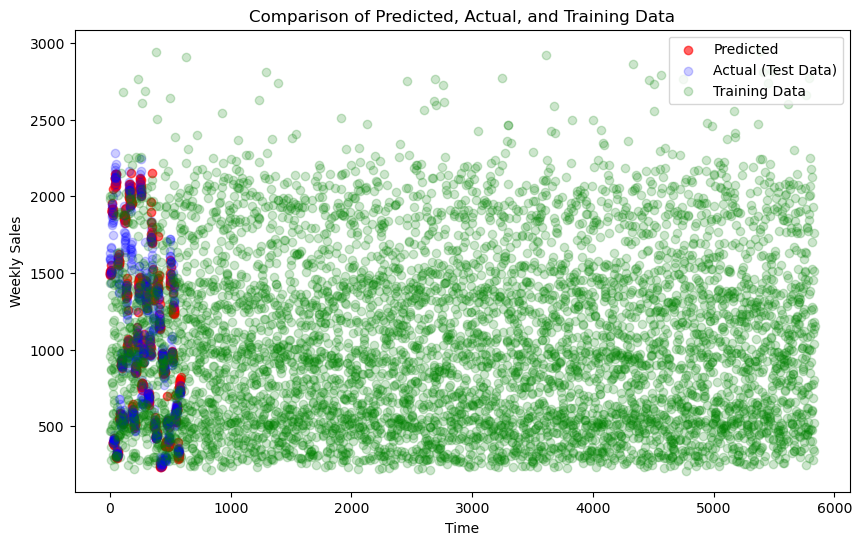

In [131]:
import matplotlib.pyplot as plt

# Plotting parameters
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Scatter plot for predicted values
plt.scatter(range(len(lasso_yhat)), lasso_yhat, color='red', label='Predicted',alpha = 0.6)

# Scatter plot for actual values (test data)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual (Test Data)',alpha = 0.2)

# Scatter plot for training data
plt.scatter(range(len(y_train)), y_train, color='green', label='Training Data',alpha = 0.2)

# Set the x-axis label and title
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Predicted, Actual, and Training Data')

# Add a legend
plt.legend()

# Show the plot
plt.show()
